In [1]:
# Import tools to get datasets
from zipfile import ZipFile

# Data Manipulation
import pandas as pd
import numpy as np

# Telling-Story Tools
from matplotlib import pyplot as plt, cm
import pandas.io.formats.style

In [2]:
# cd ~/.kaggle
# !mv ~/Downloads/kaggle.json ./
# !chmod 600 ./kaggle.json

In [3]:
!kaggle datasets download -d wenruliu/adult-income-dataset

Traceback (most recent call last):
  File "/Users/jonahwinninghoff/opt/anaconda3/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/Users/jonahwinninghoff/opt/anaconda3/lib/python3.8/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/Users/jonahwinninghoff/opt/anaconda3/lib/python3.8/site-packages/kaggle/api/kaggle_api_extended.py", line 169, in authenticate
    self._load_config(config_data)
  File "/Users/jonahwinninghoff/opt/anaconda3/lib/python3.8/site-packages/kaggle/api/kaggle_api_extended.py", line 210, in _load_config
    raise ValueError('Error: Missing %s in configuration.' % item)
ValueError: Error: Missing username in configuration.


In [4]:
unzipfile = ZipFile('adult-income-dataset.zip')
file = unzipfile.open("adult.csv")
df = pd.read_csv(file)
file.close()

In [5]:
# Reduce the number of categories
recatogerized = {'No HS Diploma':['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th'],
                 'High Diploma':'HS-grad','Some College or Associate':['Assoc-voc','Assoc-acdm','Some-college'],
                 'Bachelors':'Bachelors','Graduate or Professional':['Masters','Doctorate','Prof-school']}

# Tag the categories with numbers for order purpose
order = {}
for i in enumerate(list(recatogerized.keys())):
    order[i[0]] = i[1]

In [6]:
# Recategorize using lambda if else
for k in recatogerized.keys():
    df.education = df.education.apply(lambda x: k if x in recatogerized[k] else x)

# Instantiate the new column
df['order'] = df['education']

# Create the order column
for k in order.keys():
    df['order'] = df.order.apply(lambda x: k if x == order[k] else x)

In [7]:
# Merge two columns into one
df["fororder"] = df["order"].astype('str') +': '+ df["education"]

In [8]:
# Separate two datasets <=50K vs >50K
lowerincome = df[df['income'] == '<=50K']
highincome = df[df['income'] != '<=50K']

In [9]:
# Group education and count and sort index based on fororder
lowerincome = lowerincome.groupby('fororder')[['education']].count().sort_index().reset_index()
highincome = highincome.groupby('fororder')[['education']].count().sort_index().reset_index()

# Remove the first three letters
highincome['fororder']= highincome['fororder'].str[3:]
lowerincome['fororder']= lowerincome['fororder'].str[3:]

# Rename the columns
highincome = highincome.rename(columns = {'fororder':'Education Level','education':'Count'})
lowerincome = lowerincome.rename(columns = {'fororder':'Education Level','education':'Count'})

In [10]:
# Change Count into Percentage
lowerincome['Percentage'] = round(lowerincome['Count']/sum(lowerincome['Count']),3)
highincome['Percentage'] = round(highincome['Count']/sum(highincome['Count']),3)

In [11]:
# Set up the data for stacked bar
names = list(highincome['Education Level'])
thedict = {
    'Income Higher than 50K': highincome['Percentage'],
    'Income Lower than 50K': lowerincome['Percentage'],
}

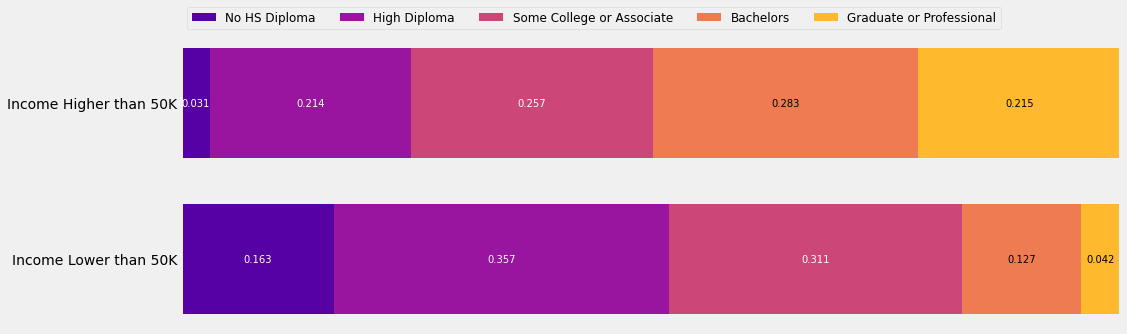

In [12]:
# Use the similar function from 
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/horizontal_barchart_distribution.html
plt.style.use('fivethirtyeight')

def stacked_plot(thedict, names):
    labels = list(thedict.keys())
    data = np.array(list(thedict.values()))
    cumulative = data.cumsum(axis=1)
    colors = plt.get_cmap('plasma')(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    fig, ax = plt.subplots(figsize=(15,5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(names, colors)):
        widths = data[:, i]
        starts = cumulative[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.7,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.11 else 'black'
        ax.bar_label(rects, label_type='center', color=text_color,fontsize=10,rotation=0)
    ax.legend(ncol=len(names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize=12)

    return fig, ax

stacked_plot(thedict, names)
plt.show()

In [13]:
lowerincome = df[df['income'] == '<=50K']
highincome = df[df['income'] != '<=50K']

lowerincome = lowerincome.groupby('race')[['education']].count().reset_index().rename(columns = {'race':'Race',
                                                                                   'education':'Count'})
highincome = highincome.groupby('race')[['education']].count().reset_index().rename(columns = {'race':'Race',
                                                                                   'education':'Count'})

In [14]:
# Separate two groups based on incomes
lowerincome = df[df['income'] == '<=50K']
highincome = df[df['income'] != '<=50K']

# Average education years and difference between high income and lower income with five races
lowerincome = round(lowerincome.groupby('race')[['educational-num']].mean().reset_index().rename(
    columns = {'race':'Race'}),0)
highincome = round(highincome.groupby('race')[['educational-num']].mean().reset_index().rename(
    columns = {'race':'Race'}),0)

In [15]:
# Self-Join Using Inner by Race
forlollipop = highincome.merge(lowerincome, on='Race',how='inner').rename(columns = {
    'educational-num_x':'Higher than 50K',
    'educational-num_y':'Lower than 50K'})

# Sort high income average education years 
ordered_lollipop = forlollipop.sort_values(by='Higher than 50K', ascending=False)
ordered_lollipop = pd.concat([ordered_lollipop[(ordered_lollipop['Race'] == 'Other')],
                             ordered_lollipop[~(ordered_lollipop['Race'] == 'Other')]],axis=0)

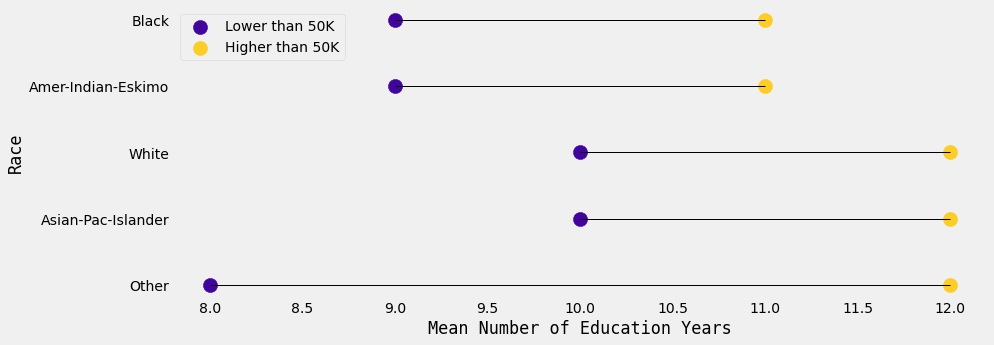

In [16]:
# Color Machine Maker 
cmap = cm.get_cmap('plasma')

# The horizontal plot is made using the hline function
plt.figure(figsize=(13,5))
plt.hlines(y=range(1,len(forlollipop)+1), xmin=ordered_lollipop['Lower than 50K'],
           xmax=ordered_lollipop['Higher than 50K'], 
           color='black',linewidth=1)
plt.scatter(ordered_lollipop['Lower than 50K'], 
            range(1,len(forlollipop)+1), color=cmap(0.1), alpha=1,s=200, 
            label='Lower than 50K')
plt.scatter(ordered_lollipop['Higher than 50K'], 
            range(1,len(forlollipop)+1), color=cmap(0.9), alpha=1,s=200, 
            label='Higher than 50K')
 
# Add title and axis names
plt.yticks(range(1,len(forlollipop)+1), ordered_lollipop['Race'])
plt.xlabel('Mean Number of Education Years',{'fontname':'Monospace'})
plt.ylabel('Race',{'fontname':'Monospace'})
plt.grid(False)
plt.legend(loc='upper left')

# Show the graph
plt.show()

In [17]:
# Build the data for Area Plot
df['capital-profit'] = df['capital-gain']-df['capital-loss'] # Profit = Gain - Loss
for_area_plot = df[['race','capital-gain']]                # Columns: Race and Capital Profit
for_area_plot = for_area_plot[for_area_plot['capital-gain'] != 0] # Remove zeros

In [18]:
# Instaniate the dictionary
area_plot = {}

# For-loop by each race, bootstrap 10 samples and then average them 
# and sampling size equals to 100 and sort them
for k in for_area_plot.race.unique():
    thelist = [for_area_plot[for_area_plot['race'] == k]['capital-gain'].sample(
    10,replace = True).mean() for i in range(100)]
    thelist.sort()
    area_plot[k] = thelist

# Add order
area_plot['order'] = range(100)

In [20]:
area_plot/area_plot.sum(axis=0)

AttributeError: 'dict' object has no attribute 'sum'

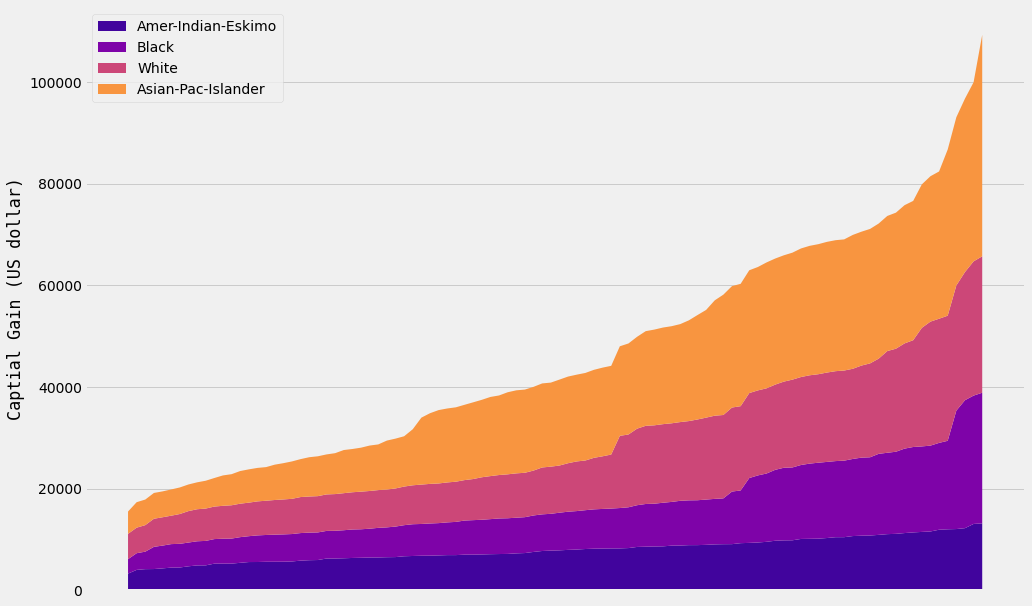

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
ax.stackplot(area_plot['order'],
             area_plot['Amer-Indian-Eskimo'],
             area_plot['Black'],
             area_plot['White'], 
             area_plot['Asian-Pac-Islander'],
             labels=['Amer-Indian-Eskimo',
                      'Black',
                      'White',
                      'Asian-Pac-Islander'],
             colors = [cmap(0.1),cmap(0.25),cmap(.5),cmap(0.75),cmap(0.9)])
ax.set_ylabel('Captial Gain (US dollar)',{'fontname':'Monospace'})
ax.axes.xaxis.set_visible(False)
plt.legend(loc='upper left')
plt.show()
